In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir


In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Rey', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training/Rey_training_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 15306.85 seconds 
duration: 4.25 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=26), thresh=8, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 420.6 seconds


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,start,stop,label,duration
0,525.4256,526.4848,None,1.0592
1,907.5878,909.1142,None,1.5264
2,1193.1820,1195.0756,None,1.8936
3,1289.0000,1325.0000,None,36.0000
4,1461.7138,1464.6570,None,2.9432
5,1476.5684,1485.5380,None,8.9696
6,1688.1572,1691.0132,None,2.8560
7,1705.0242,1708.2290,None,3.2048
8,1750.7670,1752.6990,None,1.9320
9,1759.8918,1760.9766,None,1.0848


<Axes: >

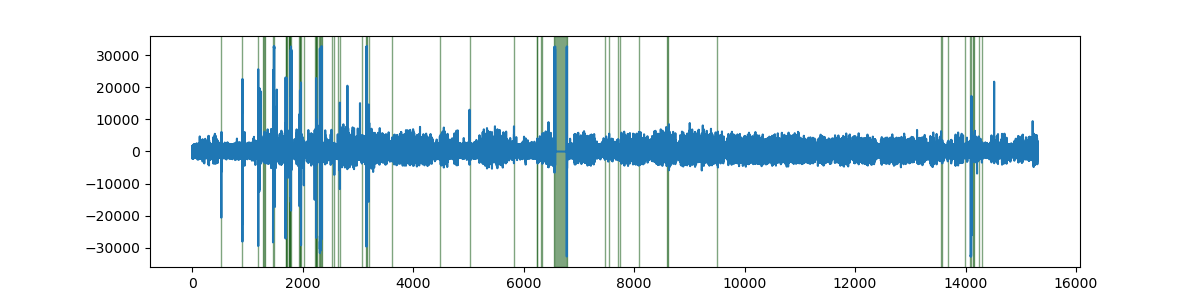

In [6]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training/Rey_training_denoised.probegroup.npy saved


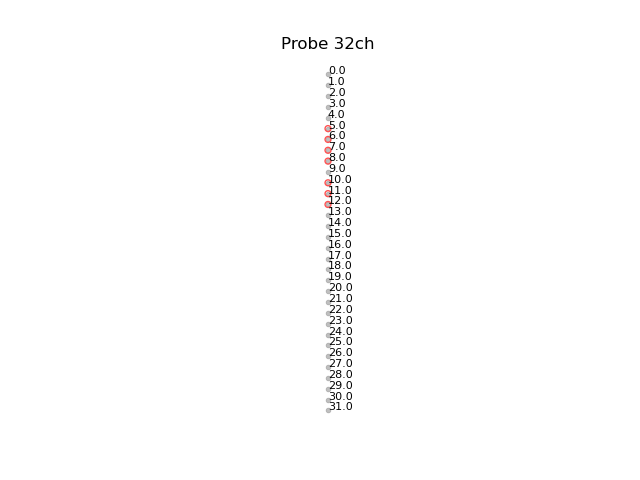

In [7]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [8]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 26

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs.save(theta_epochs_file)

Best channel for theta: [26]
1144 epochs remaining with durations within (1,20)
/data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training/Rey_training_denoised.theta_epochs.npy saved


<Axes: >

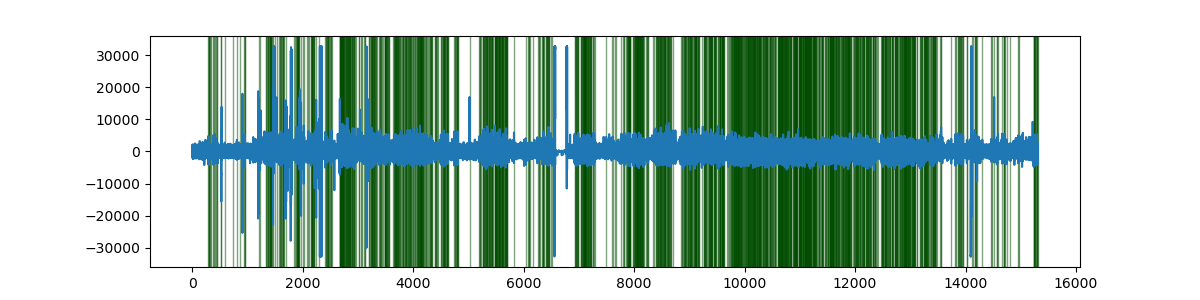

In [9]:
%matplotlib widget

chan_plot = theta_channel
plot_signal_w_epochs(signal, chan_plot, theta_epochs)

(-4000.0, 4000.0)

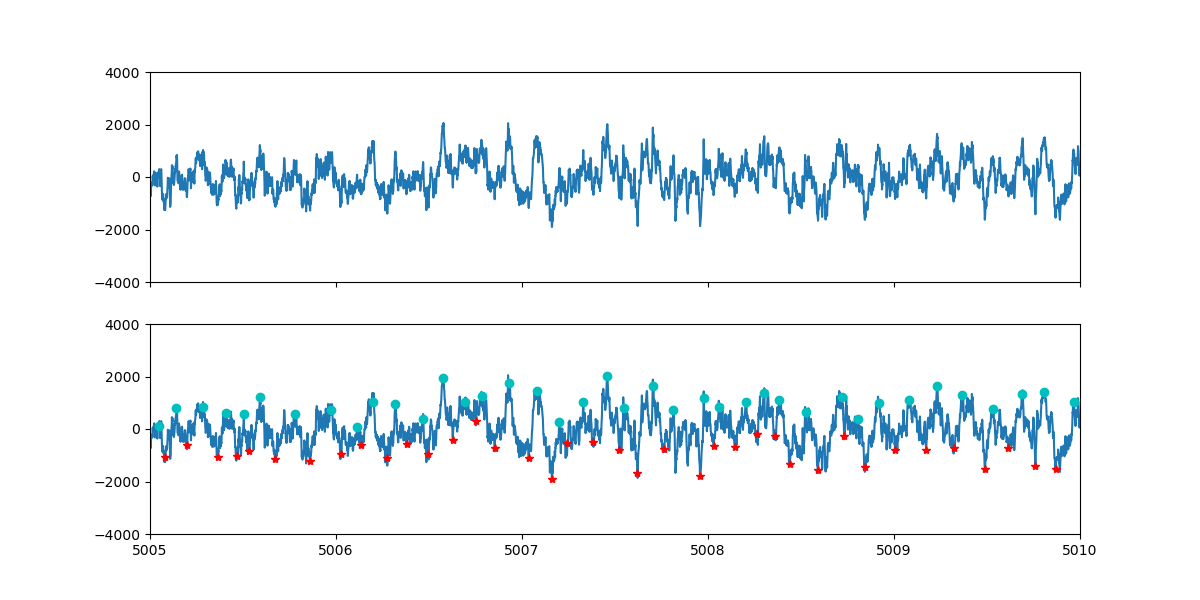

In [10]:
from neuropy.utils.signal_process import hilbert_amplitude_stat, theta_phase_specfic_extraction, ThetaParams
tparams = ThetaParams(lfp=signal.traces[theta_channel, :], fs=signal.sampling_rate, method="waveshape")
trough_indices = tparams.trough.astype(int)
peak_indices = tparams.peak.astype(int)
_, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)
plot_signal_w_epochs(signal, chan_plot, theta_epochs, ax=ax[0])
ax[1].plot(signal.time, signal.traces[theta_channel])

ax[1].plot(signal.time[trough_indices], signal.traces[theta_channel, trough_indices], 'r*')
ax[1].plot(signal.time[peak_indices], signal.traces[theta_channel, peak_indices], 'co')

ax[0].set_xlim((5005, 5010))
ax[1].set_ylim((-4000, 4000))

(-4000.0, 4000.0)

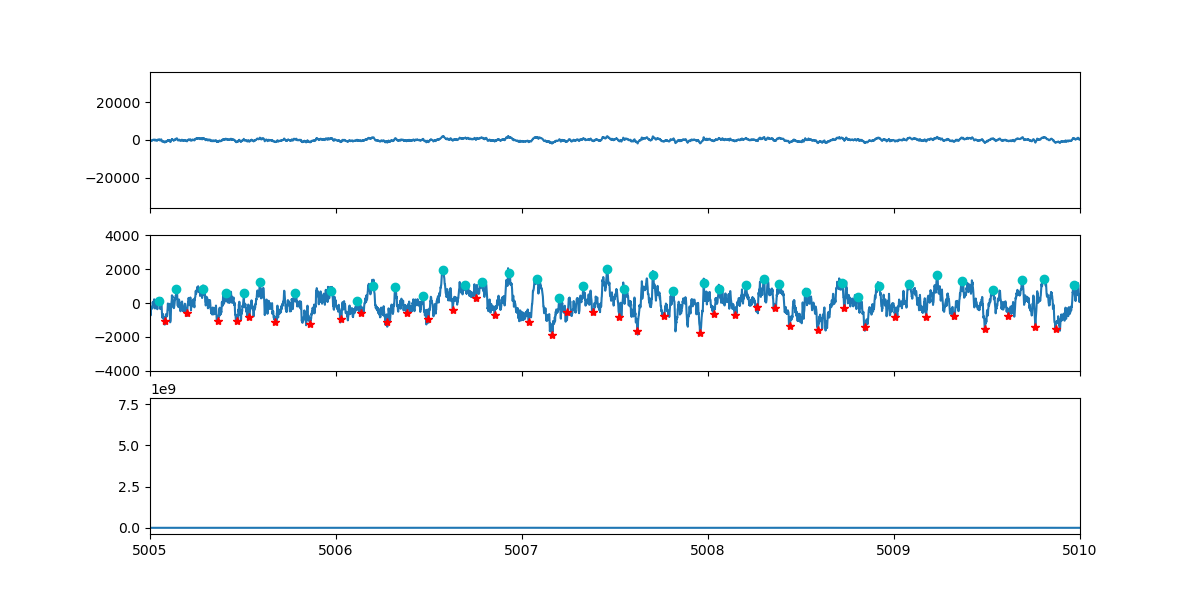

In [11]:
_, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True, sharey=False)
plot_signal_w_epochs(signal, chan_plot, theta_epochs, ax=ax[0])
ax[1].plot(signal.time, signal.traces[theta_channel])

ax[1].plot(signal.time[trough_indices], signal.traces[theta_channel, trough_indices], 'r*')
ax[1].plot(signal.time[peak_indices], signal.traces[theta_channel, peak_indices], 'co')

ax[2].plot(signal.time, tparams.amp)

ax[0].set_xlim((5005, 5010))
ax[1].set_ylim((-4000, 4000))

## Read in usv epochs

In [12]:
# Import USV epochs (from Sync_USV_and_Ephys notebook).
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs

31 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  918.489945  918.545653  454.143559  41.270313  0.058728   12.706250    1.0   
1  918.830174  918.913128  454.502235  48.738021  0.087452    9.696875    1.0   
2  919.498451  919.591260  455.206745  39.821354  0.097841   14.378125    1.0   
3  920.429279  920.545830  456.188042  41.381771  0.122870   12.594792    1.0   
4  920.954249  921.046723  456.741475  41.716146  0.097488    6.353125    1.0   

   Accept label  
0       1        
1       1        
2       1        
3       1        
4       1        

## high USV Theta phase plots

<Axes: ylabel='Count'>

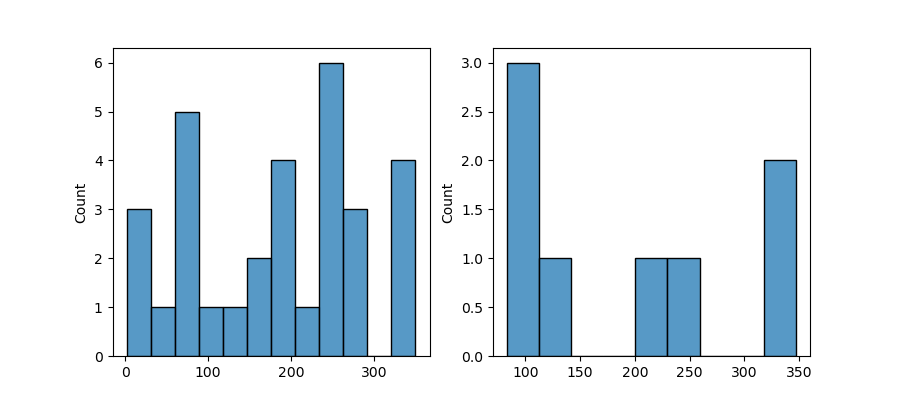

In [67]:
# First get frame number of each usv.
usv_start_frames = (usv_epochs.starts * tparams.fs).astype(int)
usv_start_frames
theta_thresh=23
# Get theta power for each call start
# high_theta_usv_start_times = theta_epochs.contains(usv_epochs.starts)  # This might be too conservative
usv_start_theta_power = theta_power[usv_start_frames]

# Only include calls with above average theta power
theta_thresh = 0  # units = std (theta power is z-scored)
high_usv_power_bool = usv_start_theta_power > theta_thresh
high_theta_usv_start_frames = usv_start_frames[high_usv_power_bool]

# Next, calculate theta phase angle at each usv start
phase_start = tparams.angle[usv_start_frames]
high_theta_phase_start = tparams.angle[high_theta_usv_start_frames]

# Plot histogram of usv start angles
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(phase_start, binwidth=30, ax=ax[0])
sns.histplot(high_theta_phase_start, binwidth=30, ax=ax[1])

In [72]:
low_usv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min<=23]
low_usv_epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label
25,939.450215,940.125713,476.240276,21.430729,0.712123,11.257292,1.000000,1,
29,953.025749,954.433019,490.551863,20.753125,1.483571,7.500000,0.624926,1,


In [73]:
high_usv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min>23]
high_usv_epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label
0,918.489945,918.545653,454.143559,41.270313,0.058728,12.706250,1.000000,1,
1,918.830174,918.913128,454.502235,48.738021,0.087452,9.696875,1.000000,1,
2,919.498451,919.591260,455.206745,39.821354,0.097841,14.378125,1.000000,1,
3,920.429279,920.545830,456.188042,41.381771,0.122870,12.594792,1.000000,1,
4,920.954249,921.046723,456.741475,41.716146,0.097488,6.353125,1.000000,1,
5,921.182381,922.022142,456.981976,25.000000,0.885293,11.625000,0.542208,1,
6,922.692401,922.755686,458.573868,37.926563,0.066716,7.356250,1.000000,1,
7,922.753177,923.396777,458.637939,24.486323,0.678496,6.125000,0.545081,1,
8,923.609932,923.674744,459.541147,40.601562,0.068327,13.820833,1.000000,1,
9,925.000734,925.052613,461.007357,43.388021,0.054691,9.473958,1.000000,1,


In [76]:
# #Histogram for low USVs
# # First get frame number of each usv.
# low_usv_start_frames = (low_usv_epochs.start * tparams.fs).astype(int)
# low_usv_start_frames

# # Get theta power for each call start
# # high_theta_usv_start_times = theta_epochs.contains(usv_epochs.starts)  # This might be too conservative
# low_usv_start_theta_power = theta_power[low_usv_start_frames]

# # Only include calls with above average theta power
# theta_thresh = 0  # units = std (theta power is z-scored)
# high_usv_power_bool = low_usv_start_theta_power > theta_thresh
# high_theta_usv_start_frames = low_usv_start_frames[high_usv_power_bool]

# # Next, calculate theta phase angle at each usv start
# phase_start = tparams.angle[low_usv_start_frames]
# high_theta_phase_start = tparams.angle[high_theta_usv_start_frames]

# # Plot histogram of usv start angles
# _, ax = plt.subplots(1, 2, figsize=(9, 4))
# sns.histplot(phase_start, binwidth=30, ax=ax[0])
# sns.histplot(high_theta_phase_start, binwidth=30, ax=ax[1])

<Axes: ylabel='Count'>

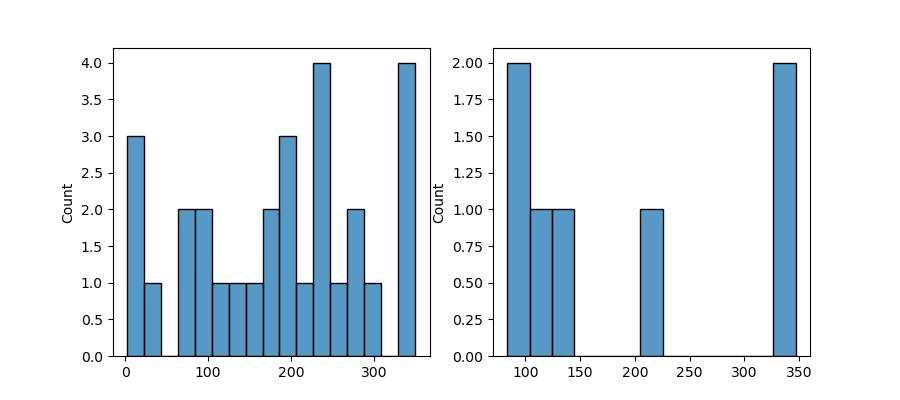

In [77]:
#Histogram for high USVs
# First get frame number of each usv.
high_usv_start_frames = (high_usv_epochs.start * tparams.fs).astype(int)
high_usv_start_frames

# Get theta power for each call start
# high_theta_usv_start_times = theta_epochs.contains(usv_epochs.starts)  # This might be too conservative
high_usv_start_theta_power = theta_power[high_usv_start_frames]

# Only include calls with above average theta power
theta_thresh = 0  # units = std (theta power is z-scored)
high_usv_power_bool = high_usv_start_theta_power > theta_thresh
high_theta_usv_start_frames = high_usv_start_frames[high_usv_power_bool]

# Next, calculate theta phase angle at each usv start
phase_start = tparams.angle[high_usv_start_frames]
high_theta_phase_start = tparams.angle[high_theta_usv_start_frames]

# Plot histogram of usv start angles
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(phase_start, binwidth=20, ax=ax[0])
sns.histplot(high_theta_phase_start, binwidth=20, ax=ax[1])

In [78]:
# _, ax = plt.subplots()
# ax.plot(usv_start_theta_power, '.')

In [79]:
theta_epochs

1144 epochs
Snippet: 
       start      stop  peak_time  peak_power label
0  291.7744  294.0824   293.3168    5.707191      
1  301.1000  303.5928   302.8752    4.867292      
2  303.6304  305.0240   304.6240    3.848490      
3  329.1408  330.2672   329.7000    2.826197      
4  383.5752  386.1776   385.5680    4.312324      

## high/low USV and theta epoch plot

/tmp/ipykernel_1475747/4055957558.py:18: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.6), duration, 0.4, color='blue', edgecolor='none', alpha=0.5)
/tmp/ipykernel_1475747/4055957558.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.1), duration, 0.4, color='green', edgecolor='none', alpha=0.5)


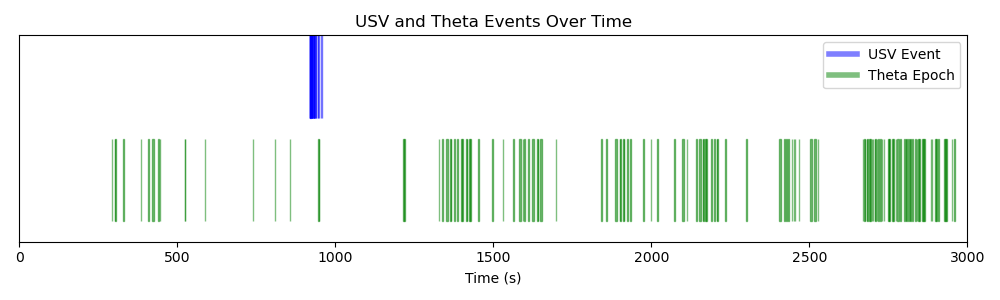

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

usv_start_times = usv_epochs.starts 
usv_stop_times = usv_epochs.stops  
usv_durations = usv_epochs.stops-usv_epochs.starts  

theta_start_times = theta_epochs.starts  
theta_stop_times = theta_epochs.stops  
theta_durations = theta_stop_times - theta_start_times 

fig, ax = plt.subplots(figsize=(10, 3))  

# Plot USV events
for start_time, duration in zip(usv_start_times, usv_durations):
    rect = Rectangle((start_time, 0.6), duration, 0.4, color='blue', edgecolor='none', alpha=0.5)
    ax.add_patch(rect)

# Plot Theta epochs
for start_time, duration in zip(theta_start_times, theta_durations):
    rect = Rectangle((start_time, 0.1), duration, 0.4, color='green', edgecolor='none', alpha=0.5)
    ax.add_patch(rect)


from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=4, alpha=0.5), Line2D([0], [0], color='green', lw=4, alpha=0.5)]
ax.legend(custom_lines, ['USV Event', 'Theta Epoch'])

ax.set_xlim(0, 3000)
ax.set_ylim(0, 1)
ax.set_xlabel('Time (s)')
ax.set_yticks([])
plt.title('USV and Theta Events Over Time')
plt.tight_layout()
plt.show()

## Example Code for Cross-correlogram between USVs and Theta
Could do the same thing for ripples

In [21]:
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_usv_on_times = [theta_epochs.stops, usv_epochs.starts]
theta_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_usv_on_times)])
theta_off_usv_on_times = np.hstack(theta_off_usv_on_times)
sort_ids = np.argsort(theta_off_usv_on_times)

theta_off_usv_on_times = theta_off_usv_on_times[sort_ids]
theta_off_usv_on_ids = theta_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_usv_on_times, theta_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)

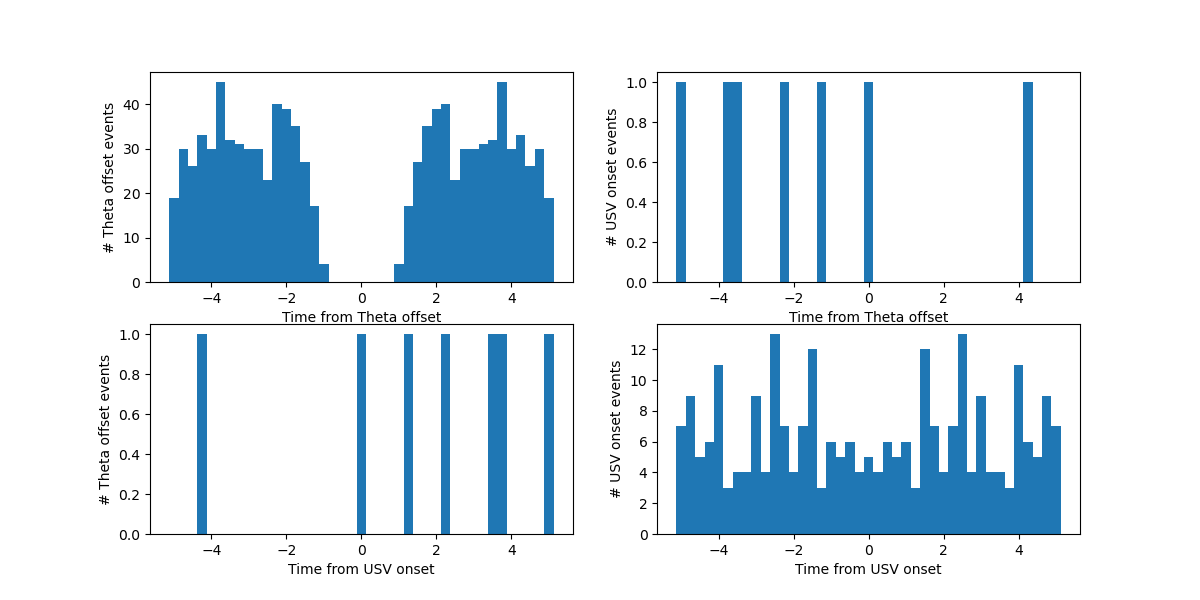

In [22]:
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

In [23]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 26
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [26]
7908 epochs remaining with durations within (0.05,0.45)
/data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training/Rey_training_denoised.ripple_epochs.npy saved


In [24]:
# Convert ripple epochs to binned ripple rate
t, rip_bool = ripple_epochs.to_point_process()
from neuropy.core.neurons import BinnedSpiketrain, Neurons
rips = Neurons(t[None, rip_bool], t_stop=50*60)

In [25]:
bin_size_sec = 10
binned_rips = rips.get_binned_spiketrains(bin_size=bin_size_sec)

In [26]:
lowusv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min<=23]
lowusv_epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label
25,939.450215,940.125713,476.240276,21.430729,0.712123,11.257292,1.000000,1,
29,953.025749,954.433019,490.551863,20.753125,1.483571,7.500000,0.624926,1,


In [27]:
highusv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min>23]
highusv_epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label
0,918.489945,918.545653,454.143559,41.270313,0.058728,12.706250,1.000000,1,
1,918.830174,918.913128,454.502235,48.738021,0.087452,9.696875,1.000000,1,
2,919.498451,919.591260,455.206745,39.821354,0.097841,14.378125,1.000000,1,
3,920.429279,920.545830,456.188042,41.381771,0.122870,12.594792,1.000000,1,
4,920.954249,921.046723,456.741475,41.716146,0.097488,6.353125,1.000000,1,
5,921.182381,922.022142,456.981976,25.000000,0.885293,11.625000,0.542208,1,
6,922.692401,922.755686,458.573868,37.926563,0.066716,7.356250,1.000000,1,
7,922.753177,923.396777,458.637939,24.486323,0.678496,6.125000,0.545081,1,
8,923.609932,923.674744,459.541147,40.601562,0.068327,13.820833,1.000000,1,
9,925.000734,925.052613,461.007357,43.388021,0.054691,9.473958,1.000000,1,


## All theta USV CCG

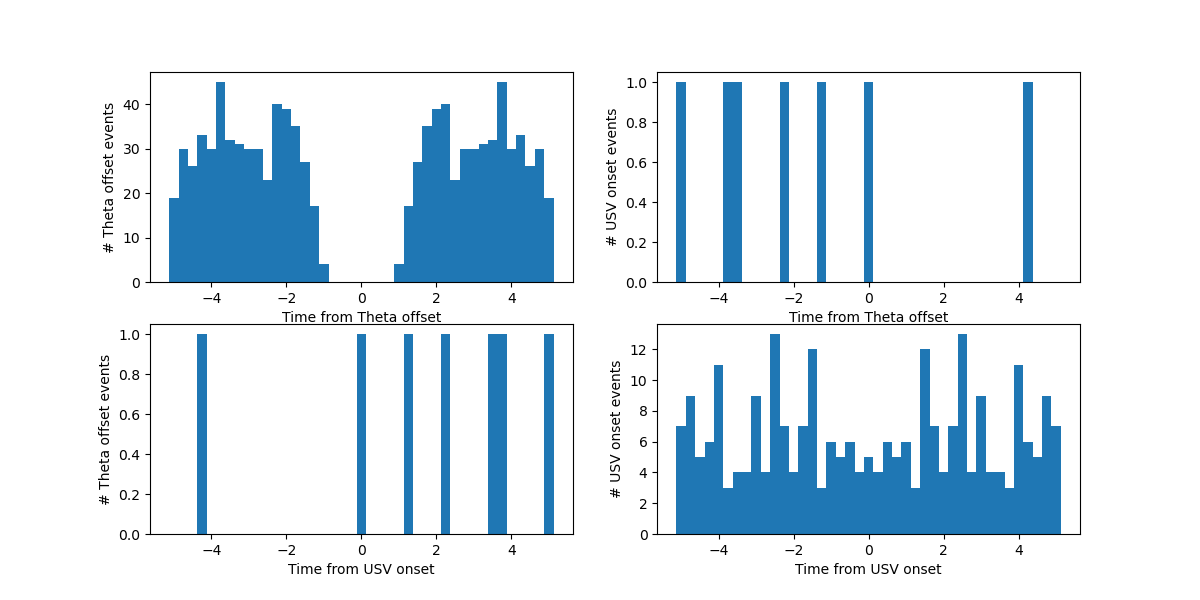

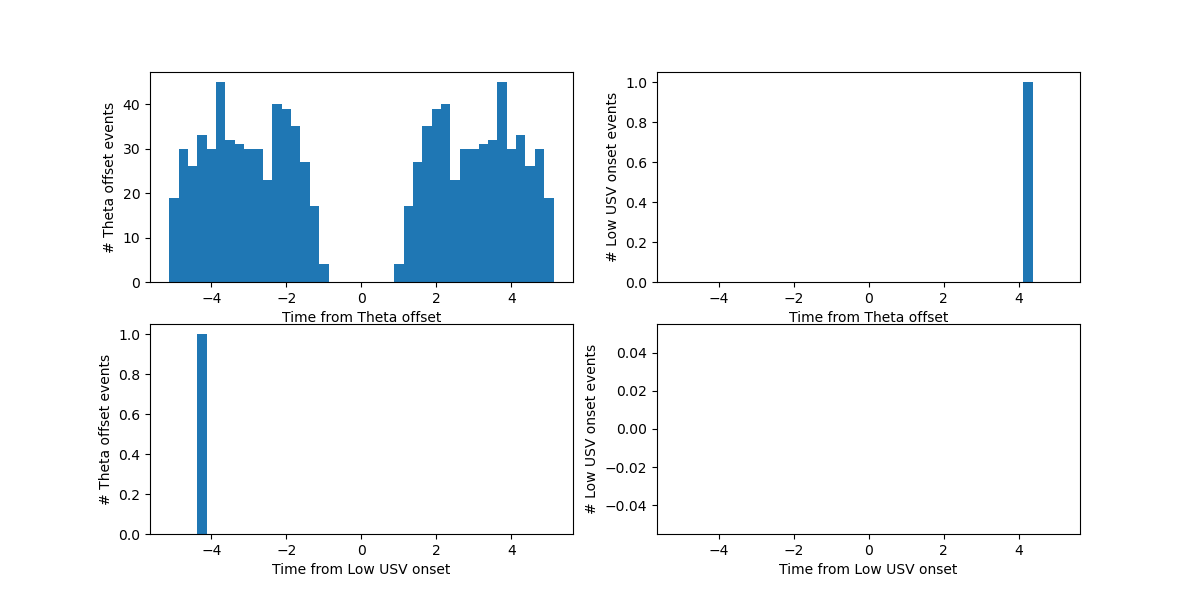

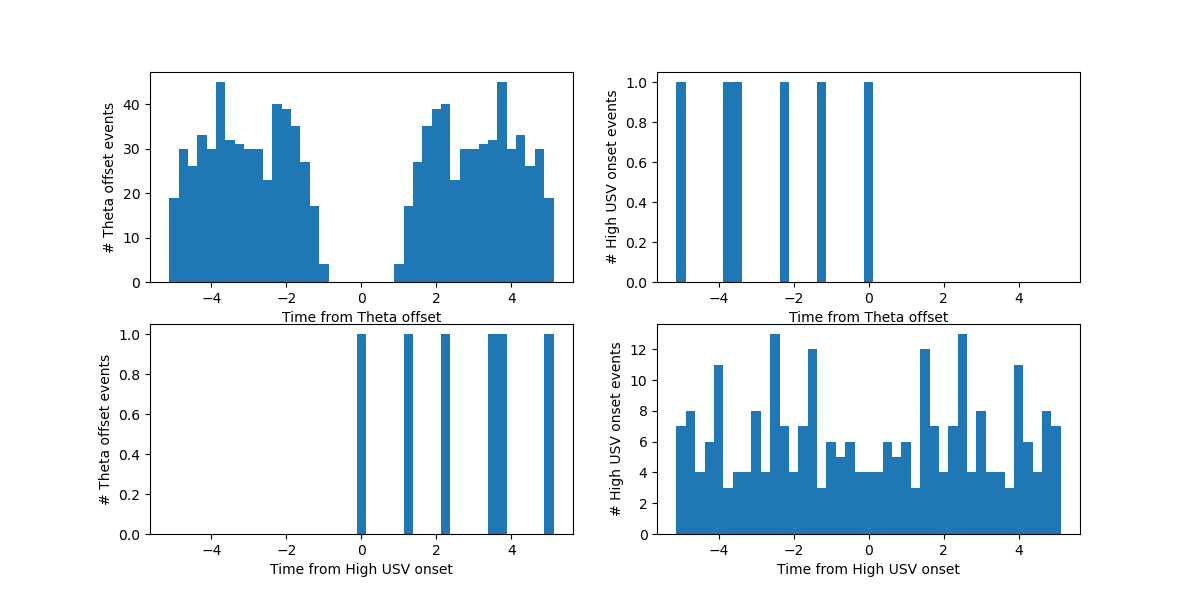

In [28]:
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_usv_on_times = [theta_epochs.stops, usv_epochs.starts]
theta_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_usv_on_times)])
theta_off_usv_on_times = np.hstack(theta_off_usv_on_times)
sort_ids = np.argsort(theta_off_usv_on_times)

theta_off_usv_on_times = theta_off_usv_on_times[sort_ids]
theta_off_usv_on_ids = theta_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_usv_on_times, theta_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr1_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

corr1_fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-theta ccg all.png')

#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_lowusv_on_times = [theta_epochs.stops, lowusv_epochs.start]
theta_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_lowusv_on_times)])
theta_off_lowusv_on_times = np.hstack(theta_off_lowusv_on_times)
sort_ids = np.argsort(theta_off_lowusv_on_times)

theta_off_lowusv_on_times = theta_off_lowusv_on_times[sort_ids]
theta_off_lowusv_on_ids = theta_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_lowusv_on_times, theta_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr2_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

corr2_fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-theta ccg lowusv.png')

#high usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_highusv_on_times = [theta_epochs.stops, highusv_epochs.start]
theta_off_highusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_highusv_on_times)])
theta_off_highusv_on_times = np.hstack(theta_off_highusv_on_times)
sort_ids = np.argsort(theta_off_highusv_on_times)

theta_off_highusv_on_times = theta_off_highusv_on_times[sort_ids]
theta_off_highusv_on_ids = theta_off_highusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_highusv_on_times, theta_off_highusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr3_fig, ax = plt.subplots(2, 2, figsize=(12, 6))


var_names = ['Theta offset', 'High USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr3_fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-theta ccg highusv.png')

## All ripple USv CCG

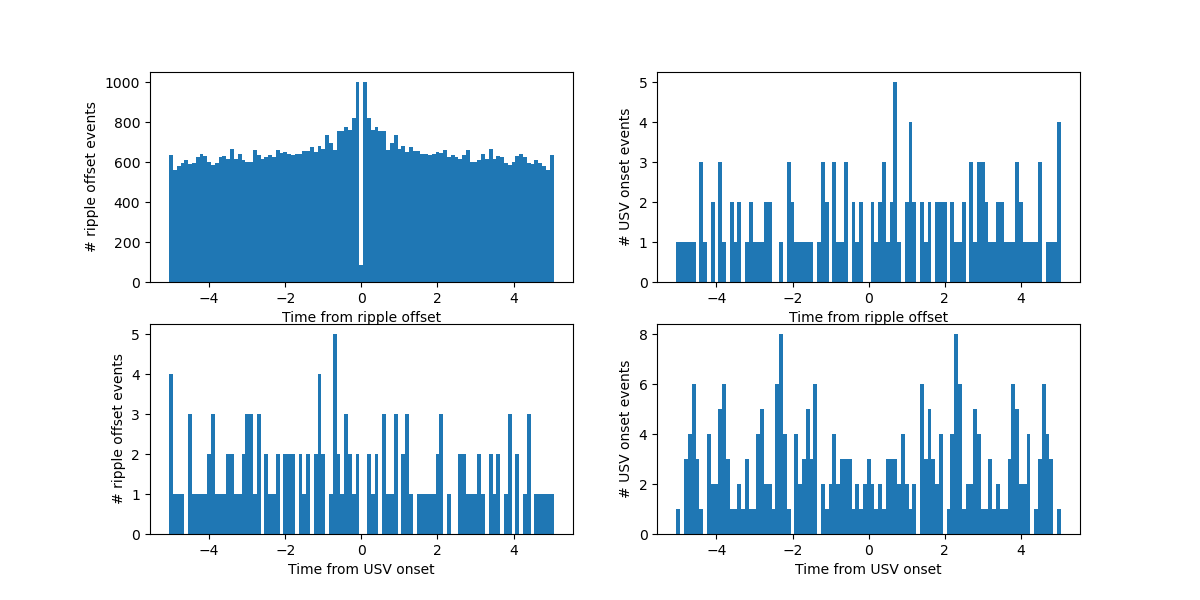

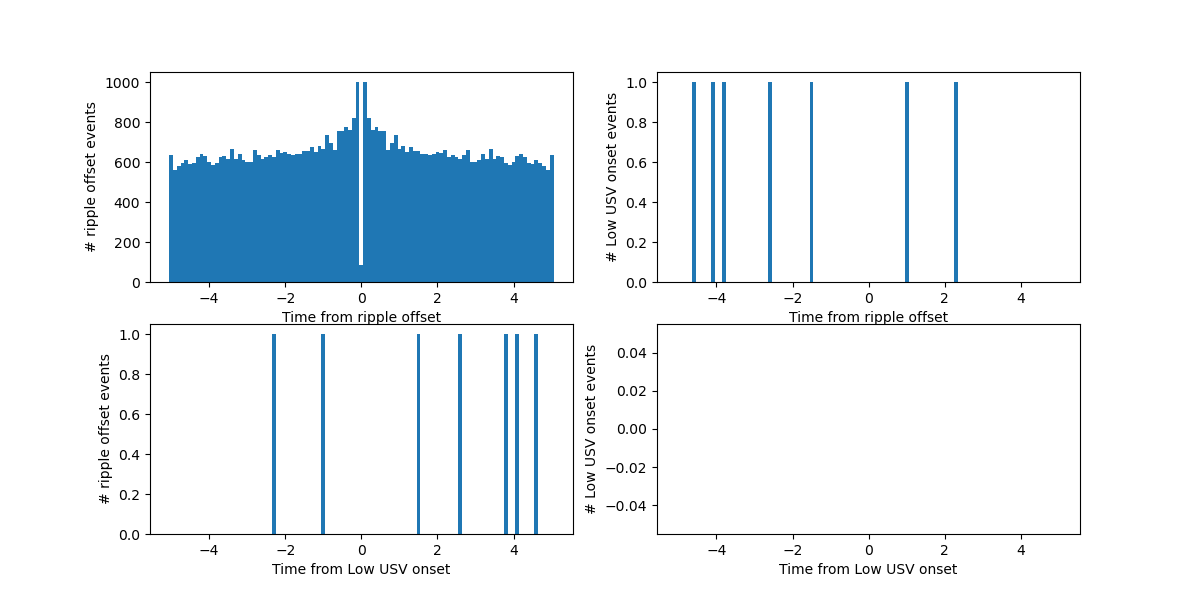

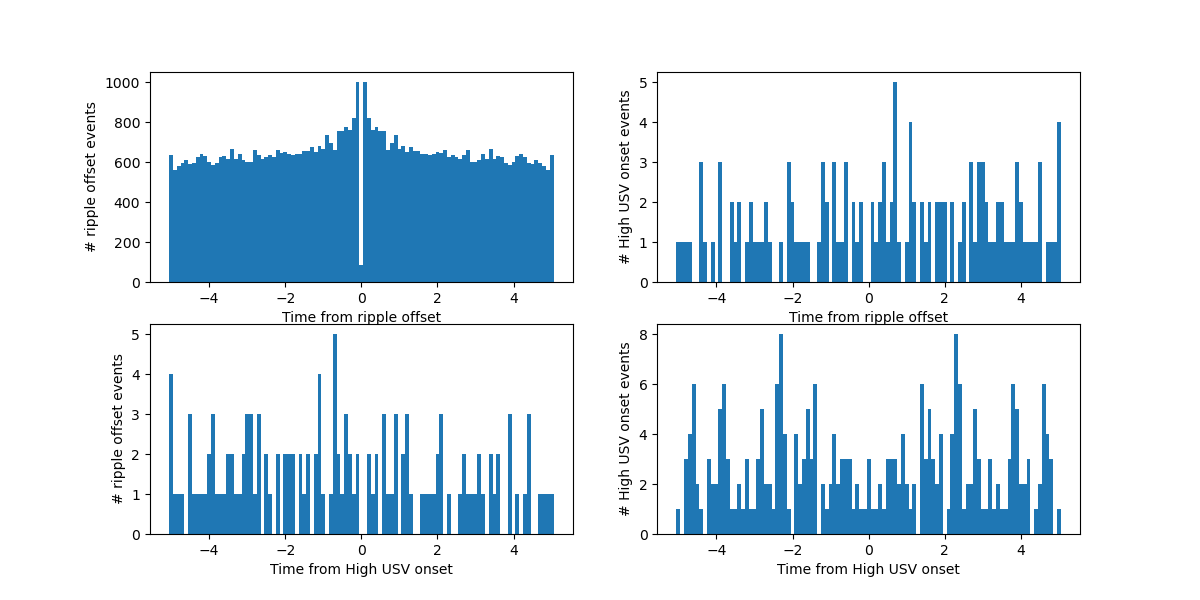

In [29]:
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_usv_on_times = [ripple_epochs.stops, usv_epochs.starts]
ripple_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_usv_on_times)])
ripple_off_usv_on_times = np.hstack(ripple_off_usv_on_times)
sort_ids = np.argsort(ripple_off_usv_on_times)

ripple_off_usv_on_times = ripple_off_usv_on_times[sort_ids]
ripple_off_usv_on_ids = ripple_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_usv_on_times, ripple_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr4_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr4_fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-ripple ccg all.png')

#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_lowusv_on_times = [ripple_epochs.stops, lowusv_epochs.start]
ripple_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_lowusv_on_times)])
ripple_off_lowusv_on_times = np.hstack(ripple_off_lowusv_on_times)
sort_ids = np.argsort(ripple_off_lowusv_on_times)

ripple_off_lowusv_on_times = ripple_off_lowusv_on_times[sort_ids]
ripple_off_lowusv_on_ids = ripple_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_lowusv_on_times, ripple_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr5_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr5_fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-ripple ccg lowusv.png')

#high usv
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_highusv_on_times = [ripple_epochs.stops, highusv_epochs.start]
ripple_off_highusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_highusv_on_times)])
ripple_off_highusv_on_times = np.hstack(ripple_off_highusv_on_times)
sort_ids = np.argsort(ripple_off_highusv_on_times)

ripple_off_highusv_on_times = ripple_off_highusv_on_times[sort_ids]
ripple_off_highusv_on_ids = ripple_off_highusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_highusv_on_times, ripple_off_highusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr6_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'High USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr6_fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-ripple ccg highusv.png')

In [30]:
signal.time_slice(t_start=usv_epochs.starts[0], t_stop=usv_epochs.stops[0])

## USV/nonUSV theta power

In [31]:
theta_power_sg = core.signal.Signal(theta_power, signal.sampling_rate)

In [32]:
recording_duration = 3000 
theta_power_usvs = []
theta_power_non_usvs = []

for i, usv_epoch in enumerate(usv_epochs):
    if usv_epoch.stops > recording_duration:

        usv_epoch.stops = recording_duration
    

    power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=min(usv_epoch.stops, recording_duration))
    theta_power_usvs.append(power_slice.traces[0].mean())


    next_start = usv_epochs[i+1].starts if i+1 < len(usv_epochs) else recording_duration

    if usv_epoch.stops < next_start and (next_start - usv_epoch.stops) > 1:
        power_slice = theta_power_sg.time_slice(t_start=usv_epoch.stops, t_stop=next_start)
        theta_power_non_usvs.append(power_slice.traces[0].mean())


theta_power_usvs = np.array(theta_power_usvs)
theta_power_non_usvs = np.array(theta_power_non_usvs)


df1 = pd.DataFrame({"Theta Power": theta_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"Theta Power": theta_power_non_usvs, "Epoch": "non-USV"})
theta_power_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

theta_power_df

,Theta Power,Epoch
0,-0.673480,USV
1,-0.890795,USV
2,-0.491050,USV
3,0.007209,USV
4,0.688556,USV
5,-0.216636,USV
6,-0.939940,USV
7,-0.821677,USV
8,-0.846121,USV
9,-0.443742,USV


<Axes: title={'center': 'Jyn: Theta power during usv and non_usv\nMean USV: -0.3249, Mean non-USV: -0.1271'}, xlabel='Epoch', ylabel='Theta Power'>

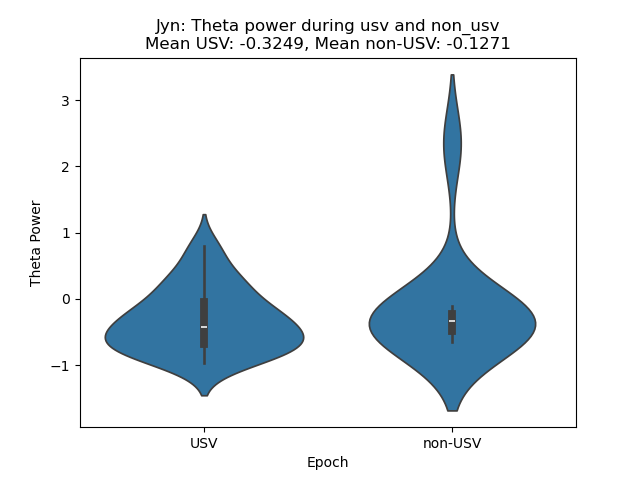

In [33]:
# Easily plot with seaborn
_, ax = plt.subplots()
title_text = f"Jyn: Theta power during usv and non_usv\nMean USV: {theta_power_usvs.mean():.4f}, Mean non-USV: {theta_power_non_usvs.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")

In [34]:
theta_power_non_usvs

array([-0.43640775, -0.52962219, -0.64627784, -0.334638  , -0.24772357,
       -0.57766775, -0.29018256,  2.34976218, -0.20101997, -0.37732064,
       -0.10739861])

## Read in frz data

In [35]:
import neuropy.io.dlcio as dlcio
dlc_path = '/data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training'
arena_side_pix = 60  # Keep this
arena_side_cm = 25.4  # Update this after measuring!!!
pix2cm = arena_side_cm / arena_side_pix

# Read in DLC data
sess.dlc = dlcio.DLC(dlc_path, pix2cm=pix2cm)

# Smooth position, get timestamps, and get speed
sess.dlc.get_timestamps('ms_webcam', include_str="2_training")
sess.dlc.smooth_pos(bodyparts=["crown_middle", "back_middle"])
sess.dlc.timestamps["Timestamps"] = sess.dlc.timestamps["Timestamps"].dt.tz_localize("America/Detroit")
sess.dlc.get_all_speed()

Using tracking file #1: /data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training/2_training/training/Rey/gobears/2022_05_09/12_16_30/My_WebCam/Rey_training_combined_movieDLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5


,back_middle,crown_middle,left_ear,neck_base,nose,right_ear,tail_base,tail_end,tail_middle
0,NaN,NaN,0.515211,0.905169,1.822689,0.450430,0.351404,0.876854,66.498583
1,NaN,NaN,1.129647,2.958141,1.287209,0.747608,0.487607,132.199561,138.755819
2,NaN,NaN,3.221762,2.088302,213.974737,0.832356,1.636033,8.059578,0.898520
3,NaN,NaN,1.642432,1.012797,3.166159,0.611040,0.961728,229.099002,200.303078
4,NaN,NaN,0.246299,0.619794,206.459708,1.356669,0.252626,84.490272,6.809151
...,...,...,...,...,...,...,...,...,...
61210,NaN,NaN,2.393919,3.799567,8.393495,6.529831,1.355460,1.809792,3.341399
61211,NaN,NaN,0.657908,2.739459,8.092463,4.615843,0.534351,4.250159,3.950690
61212,NaN,NaN,2.395407,4.620333,3.000306,4.069628,1.132349,6.870084,2.367267
61213,NaN,NaN,1.238671,2.297245,3.777264,1.383719,1.506028,1.262288,1.958646


In [36]:
# Load in openephys times to sync
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Total seconds from start"] = (sync_df["Datetime"] - sync_df["Datetime"][0]).dt.total_seconds()

# sync DLC times to your eeg file
sess.dlc.timestamps["Total seconds from OE start"] = (sess.dlc.timestamps["Timestamps"] - sync_df["Datetime"][0]).dt.total_seconds()
sess.dlc.timestamps["eeg_time"] = np.interp(sess.dlc.timestamps["Total seconds from OE start"], sync_df["Total seconds from start"], 
                                            sync_df["eeg_time"])
sess.dlc.timestamps

start time = 2022-05-09 12:06:13.678315-04:00
start time = 2022-05-09 12:15:08.781851-04:00
start time = 2022-05-09 12:33:20.854076-04:00
start time = 2022-05-09 12:39:03.160744-04:00
start time = 2022-05-09 12:48:12.124560-04:00
start time = 2022-05-09 12:54:42.702826-04:00
start time = 2022-05-09 13:04:08.630558-04:00
start time = 2022-05-09 13:58:51.401140-04:00
start time = 2022-05-09 14:08:35.718726-04:00
start time = 2022-05-09 16:10:53.170647-04:00


,Frame Number,Time Stamp (ms),Buffer Index,Timestamps,Total seconds from OE start,eeg_time
0,0,-70,0,2022-05-09 12:16:30.527000-04:00,616.848685,515.025110
1,1,28,0,2022-05-09 12:16:30.625000-04:00,616.946685,515.123110
2,2,75,0,2022-05-09 12:16:30.672000-04:00,616.993685,515.170110
3,3,106,0,2022-05-09 12:16:30.703000-04:00,617.024685,515.201110
4,4,138,0,2022-05-09 12:16:30.735000-04:00,617.056685,515.233110
...,...,...,...,...,...,...
61210,61210,2044617,0,2022-05-09 12:50:35.214000-04:00,2661.535685,2499.210641
61211,61211,2044650,0,2022-05-09 12:50:35.247000-04:00,2661.568685,2499.243641
61212,61212,2044681,0,2022-05-09 12:50:35.278000-04:00,2661.599685,2499.274641
61213,61213,2044713,0,2022-05-09 12:50:35.310000-04:00,2661.631685,2499.306641


In [37]:
# Last calculate freezing times and plot again to check
frz_thresh = 0.25 # cm/sec  Adjust this to something that looks reasonable!
duration_thresh = 2 # sec, must be below the threshold above for at least that long to be considered freezing
bodypart_use = "crown_middle"
frz_bool = sess.dlc.speed[bodypart_use] < frz_thresh
frz_epochs = Epoch.from_boolean_array(frz_bool, t=sess.dlc.timestamps["eeg_time"])
frz_df = frz_epochs.to_dataframe()
frz_df = frz_df[frz_epochs.durations > duration_thresh]

frz_epochs = Epoch(frz_df)
frz_epochs

16 epochs
Snippet: 
          start         stop  duration label
0  1366.894705  1369.774704  2.879999  high
1  1600.053951  1602.213948  2.159997  high
2  1649.541876  1652.085872  2.543996  high
3  1887.650485  1890.084479  2.433994  high
4  1899.346457  1903.410447  4.063990  high

## moving speed during highusv/lowusv/frz

In [38]:
# moving speed during frz
mean_speeds_during_freezing = []
for start, end in zip(frz_epochs.starts, frz_epochs.stops):
    epoch_speeds = sess.dlc.speed[bodypart_use][(sess.dlc.timestamps["eeg_time"] >= start) & (sess.dlc.timestamps["eeg_time"] <= end)]
    mean_speed = epoch_speeds.mean()
    mean_speeds_during_freezing.append(mean_speed)

mean_speeds_during_freezing

[0.12136936588530996,
 0.13255643156494917,
 0.1187137555755696,
 0.11078038183681402,
 0.11040471608495564,
 0.12537381470306347,
 0.12185501417815219,
 0.11752206037443326,
 0.12651980815206584,
 0.12407098793866655,
 0.12333919631865618,
 0.11682104991176384,
 0.09907360634348589,
 0.11619095742953389,
 0.10246621958698254,
 0.12217027013012344]

In [39]:
# Moving speed during high USVs
mean_speeds_during_highusv = []
for start, end in zip(highusv_epochs['start'], highusv_epochs['stop']):
    epoch_speeds = sess.dlc.speed[bodypart_use][(sess.dlc.timestamps["eeg_time"] >= start) & (sess.dlc.timestamps["eeg_time"] <= end)]
    mean_speed = epoch_speeds.mean()
    mean_speeds_during_highusv.append(mean_speed)

mean_speeds_during_highusv


[12.79687592534356,
 11.904335702119264,
 13.127479058509683,
 9.21483382765183,
 20.47319826250975,
 8.956474373084752,
 0.5685571028976689,
 0.9996183721944523,
 17.079865462420457,
 15.452892287354993,
 22.16001974477308,
 16.39214529458458,
 24.066250572532066,
 nan,
 3.915831102625271,
 0.9671401446948078,
 13.006873514687387,
 1.3628378059167936,
 1.3696729053837935,
 15.36981466026587,
 18.229924915573214,
 7.227145404160091,
 2.1510379100154684,
 1.9446005090294223,
 0.7627829424667877,
 0.679586066598069,
 0.5110390943849844,
 0.5400993902672322,
 0.5045411154389469]

In [40]:
theta_power_frz = []
theta_power_sg = core.signal.Signal(theta_power, signal.sampling_rate)
for frz_epoch in frz_epochs:

    power_slice = theta_power_sg.time_slice(t_start=frz_epoch.starts, t_stop=frz_epoch.stops)
    theta_power_frz.append(power_slice.traces[0].mean())

theta_power_frz = np.array(theta_power_frz)

frz_df = pd.DataFrame({"Theta Power": theta_power_frz, "Epoch": "Freezing"})
theta_power_df = pd.concat((df1, df2, frz_df), axis=0).reset_index()

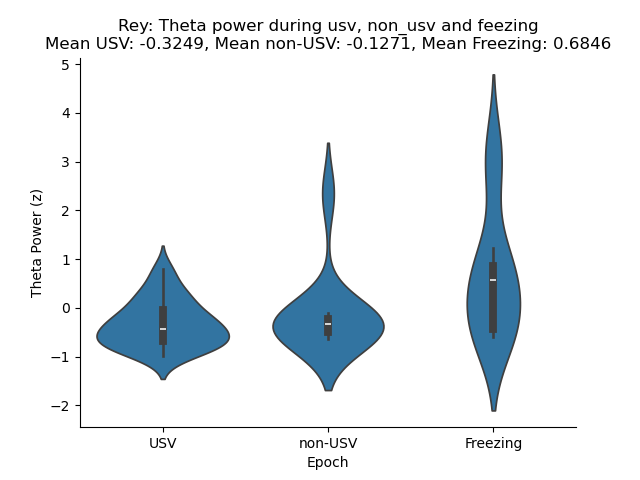

In [41]:
# Easily plot with seaborn
vio1, ax = plt.subplots()

title_text = f"Rey: Theta power during usv, non_usv and feezing\nMean USV: {theta_power_usvs.mean():.4f}, Mean non-USV: {theta_power_non_usvs.mean():.4f}, Mean Freezing: {theta_power_frz.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")
ax.set_ylabel("Theta Power (z)")
sns.despine(ax=ax)
vio1.savefig('/home/bowenw/Documents/thesisplots/Rey usv nonusv thetapower violinplot.png')

In [42]:
import pingouin as pg
pg.pairwise_tests(data=theta_power_df, dv="Theta Power", between="Epoch", padjust="bonf")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Epoch,Freezing,USV,False,True,2.981378,17.076715,two-sided,0.008350,0.025050,bonf,8.957,1.166737
1,Epoch,Freezing,non-USV,False,True,1.962236,24.923354,two-sided,0.060993,0.182978,bonf,1.426,0.687443
2,Epoch,USV,non-USV,False,True,-0.741514,12.372582,two-sided,0.472223,1.000000,bonf,0.413,-0.329998


## theta power during usv/nonusv/frz

/tmp/ipykernel_1475747/834599477.py:47: RuntimeWarning: Mean of empty slice.
  mean_theta_power_usv_during_freezing = theta_power_usv_during_freezing.mean()
/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


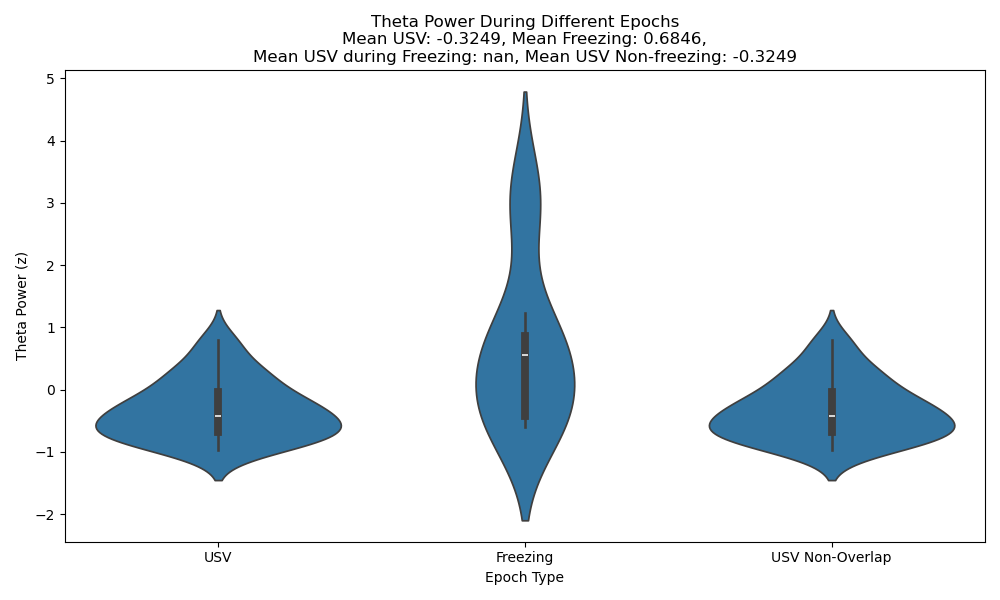

In [43]:
def categorize_usvs(usv_df, frz_df):
    usvs_during_freezing = []
    usvs_non_overlap = []
    for index, usv in usv_df.iterrows():
        overlap = False
        for _, frz in frz_df.iterrows():
            if (usv['start'] < frz['stop']) and (usv['stop'] > frz['start']):
                overlap = True
                usvs_during_freezing.append(usv)
                break
        if not overlap:
            usvs_non_overlap.append(usv)
    return pd.DataFrame(usvs_during_freezing), pd.DataFrame(usvs_non_overlap)

# Calculate the mean theta power for a given epoch type
def calculate_theta_power(signal, epochs_df):
    theta_power_values = []
    for _, epoch in epochs_df.iterrows():
        power_slice = signal.time_slice(t_start=epoch['start'], t_stop=epoch['stop'])
        theta_power_values.append(power_slice.traces[0].mean())
    return np.array(theta_power_values)

# Convert Epoch objects to DataFrames
usv_df = usv_epochs.to_dataframe()
frz_df = frz_epochs.to_dataframe()

# Categorize USVs
usv_during_freezing_df, usv_non_overlap_df = categorize_usvs(usv_df, frz_df)

# Assuming theta_power_sg is already correctly instantiated:
# Calculate theta power for each epoch type
theta_power_usv = calculate_theta_power(theta_power_sg, usv_df)
theta_power_frz = calculate_theta_power(theta_power_sg, frz_df)
theta_power_usv_during_freezing = calculate_theta_power(theta_power_sg, usv_during_freezing_df)
theta_power_usv_non_overlap = calculate_theta_power(theta_power_sg, usv_non_overlap_df)

# Create DataFrame for plotting
df_usv = pd.DataFrame({"Theta Power": theta_power_usv, "Epoch": "USV"})
df_frz = pd.DataFrame({"Theta Power": theta_power_frz, "Epoch": "Freezing"})
df_usv_during_freezing = pd.DataFrame({"Theta Power": theta_power_usv_during_freezing, "Epoch": "USV during Freezing"})
df_usv_non_overlap = pd.DataFrame({"Theta Power": theta_power_usv_non_overlap, "Epoch": "USV Non-Overlap"})

theta_power_df = pd.concat([df_usv, df_frz, df_usv_during_freezing, df_usv_non_overlap]).reset_index(drop=True)

mean_theta_power_usv = theta_power_usv.mean()
mean_theta_power_frz = theta_power_frz.mean()
mean_theta_power_usv_during_freezing = theta_power_usv_during_freezing.mean()
mean_theta_power_usv_non_freezing = theta_power_usv_non_overlap.mean()



title_text = (
    f"Theta Power During Different Epochs\n"
    f"Mean USV: {mean_theta_power_usv:.4f}, "
    f"Mean Freezing: {mean_theta_power_frz:.4f},\n"
    f"Mean USV during Freezing: {mean_theta_power_usv_during_freezing:.4f}, "
    f"Mean USV Non-freezing: {mean_theta_power_usv_non_freezing:.4f}"
)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")
plt.title(title_text)
plt.xlabel("Epoch Type")
plt.ylabel("Theta Power (z)")
plt.tight_layout()
plt.show()

In [44]:
theta_power_usvs

array([-0.67347962, -0.89079512, -0.49104991,  0.00720878,  0.68855555,
       -0.21663647, -0.93993984, -0.82167716, -0.84612058, -0.44374228,
       -0.39519119, -0.19190114, -0.54125826, -0.42431207, -0.97520152,
        0.79808066, -0.19301369, -0.71526669, -0.68625894, -0.1004135 ,
       -0.58626864,  0.05325709,  0.17986803, -0.79530246,  0.39503017,
        0.31831947, -0.63298205, -0.26467779,  0.26285654, -0.30519126,
       -0.64392195])

In [45]:
theta_power_non_usvs

array([-0.43640775, -0.52962219, -0.64627784, -0.334638  , -0.24772357,
       -0.57766775, -0.29018256,  2.34976218, -0.20101997, -0.37732064,
       -0.10739861])

In [46]:
theta_power_frz

array([-0.45335471, -0.42441002,  3.28379149,  3.09547156,  1.23655211,
        0.73571985,  0.73596175,  0.6130915 , -0.53063154, -0.40440544,
        2.80316881, -0.59551725,  0.16937049,  0.52066429, -0.43802079,
        0.60563828])

# Ripple power

In [47]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 26
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs, ripple_power = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    ripple_epochs, ripple_power = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs), return_power=True)
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [26]
7908 epochs remaining with durations within (0.05,0.45)
/data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training/Rey_training_denoised.ripple_epochs.npy saved


In [48]:
signal.time_slice(t_start=usv_epochs.starts[0], t_stop=usv_epochs.stops[0])

In [49]:
ripple_power_sg = core.signal.Signal(ripple_power, signal.sampling_rate)

## Ripple power during usv/non-usv/frz

In [50]:
recording_duration = 3000 
ripple_power_usvs = []
ripple_power_non_usvs = []

for i, usv_epoch in enumerate(usv_epochs):
    if usv_epoch.stops > recording_duration:
        usv_epoch.stops = recording_duration
    
    power_slice = ripple_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=min(usv_epoch.stops, recording_duration))
    ripple_power_usvs.append(power_slice.traces[0].mean())

    next_start = usv_epochs[i+1].starts if i+1 < len(usv_epochs) else recording_duration

    if usv_epoch.stops < next_start and (next_start - usv_epoch.stops) > 2:
        power_slice = ripple_power_sg.time_slice(t_start=usv_epoch.stops, t_stop=next_start)
        ripple_power_non_usvs.append(power_slice.traces[0].mean())


ripple_power_usvs = np.array(ripple_power_usvs)
ripple_power_non_usvs = [x for x in ripple_power_non_usvs if not np.isnan(x)]
ripple_power_non_usvs = np.array(ripple_power_non_usvs)


df1 = pd.DataFrame({"ripple Power": ripple_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"ripple Power": ripple_power_non_usvs, "Epoch": "non-USV"})
ripple_power_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

ripple_power_df

,ripple Power,Epoch
0,0.671884,USV
1,0.987469,USV
2,0.243345,USV
3,0.254415,USV
4,0.346615,USV
5,0.521592,USV
6,-0.127733,USV
7,0.111625,USV
8,1.165754,USV
9,0.721700,USV


In [51]:
ripple_power_non_usvs

array([0.19296127, 0.2153828 , 0.22491527, 0.33173535, 0.15365383,
       0.2874713 , 0.16849608, 0.14982163])

/tmp/ipykernel_1475747/240225507.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots()


<Axes: title={'center': 'Rey: ripple power during usv and non_usv\nMean USV: 0.2885, Mean non-USV: 0.2156'}, xlabel='Epoch', ylabel='ripple Power'>

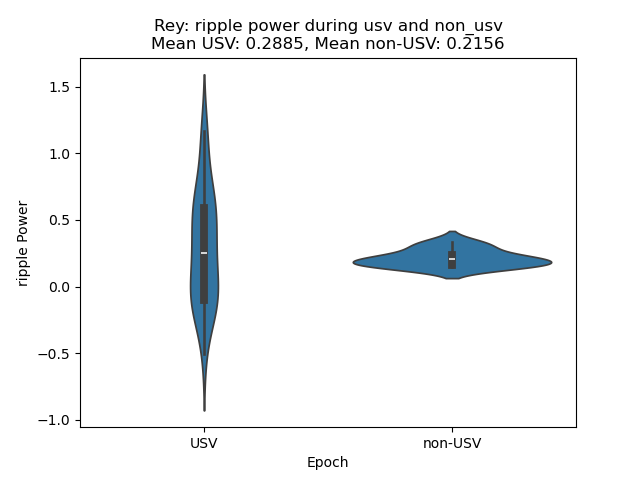

In [52]:
# Easily plot with seaborn
_, ax = plt.subplots()
title_text = f"Rey: ripple power during usv and non_usv\nMean USV: {ripple_power_usvs.mean():.4f}, Mean non-USV: {ripple_power_non_usvs.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=ripple_power_df, x="Epoch", y="ripple Power")

In [53]:
ripple_power_non_usvs

array([0.19296127, 0.2153828 , 0.22491527, 0.33173535, 0.15365383,
       0.2874713 , 0.16849608, 0.14982163])

In [54]:
# Last calculate freezing times and plot again to check
frz_thresh = 0.25 # cm/sec  Adjust this to something that looks reasonable!
duration_thresh = 1 # sec, must be below the threshold above for at least that long to be considered freezing
bodypart_use = "crown_middle"
frz_bool = sess.dlc.speed[bodypart_use] < frz_thresh
frz_epochs = Epoch.from_boolean_array(frz_bool, t=sess.dlc.timestamps["eeg_time"])
frz_df = frz_epochs.to_dataframe()
frz_df = frz_df[frz_epochs.durations > duration_thresh]

frz_epochs = Epoch(frz_df)
frz_epochs

58 epochs
Snippet: 
          start         stop  duration label
0  1330.062723  1331.070722  1.008000  high
1  1347.006715  1348.142714  1.135999  high
2  1366.894705  1369.774704  2.879999  high
3  1370.462704  1371.870703  1.407999  high
4  1379.198699  1380.430699  1.231999  high

In [55]:
ripple_power_frz = []
ripple_power_sg = core.signal.Signal(ripple_power, signal.sampling_rate)
for frz_epoch in frz_epochs:

    power_slice = ripple_power_sg.time_slice(t_start=frz_epoch.starts, t_stop=frz_epoch.stops)
    ripple_power_frz.append(power_slice.traces[0].mean())

ripple_power_frz = np.array(ripple_power_frz)

frz_df = pd.DataFrame({"ripple Power": ripple_power_frz, "Epoch": "Freezing"})
ripple_power_df = pd.concat((df1, df2, frz_df), axis=0).reset_index()

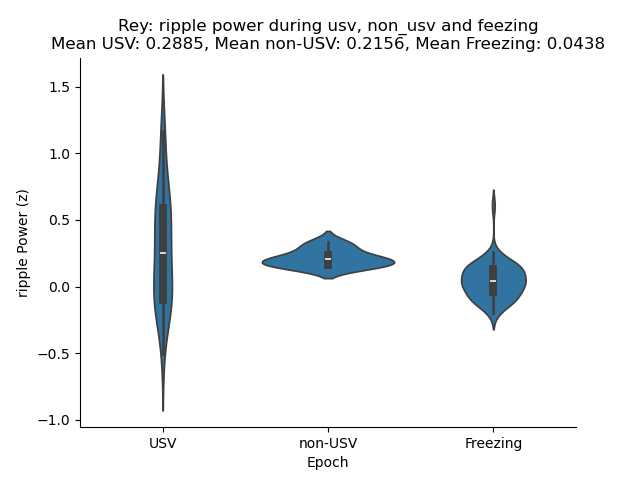

In [56]:
# Easily plot with seaborn
vio1r, ax = plt.subplots()

title_text = f"Rey: ripple power during usv, non_usv and feezing\nMean USV: {ripple_power_usvs.mean():.4f}, Mean non-USV: {ripple_power_non_usvs.mean():.4f}, Mean Freezing: {ripple_power_frz.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=ripple_power_df, x="Epoch", y="ripple Power")
ax.set_ylabel("ripple Power (z)")
sns.despine(ax=ax)
vio1r.savefig('/home/bowenw/Documents/thesisplots/Rey usv nonusv ripplepower violinplot.png')

In [57]:
import pingouin as pg
pg.pairwise_tests(data=ripple_power_df, dv="ripple Power", between="Epoch", padjust="bonf")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Epoch,Freezing,USV,False,True,-3.133765,33.242263,two-sided,0.003593,0.010780,bonf,14.627,-0.894024
1,Epoch,Freezing,non-USV,False,True,-5.930141,16.863130,two-sided,0.000017,0.000051,bonf,6.397e+04,-1.323604
2,Epoch,USV,non-USV,False,True,0.917955,34.501795,two-sided,0.365015,1.000000,bonf,0.497,0.186869


## theta power during USV/frz/usv during non-frz (all usv are during non-frz)

/tmp/ipykernel_1475747/3734984175.py:47: RuntimeWarning: Mean of empty slice.
  mean_ripple_power_usv_during_freezing = ripple_power_usv_during_freezing.mean()
/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


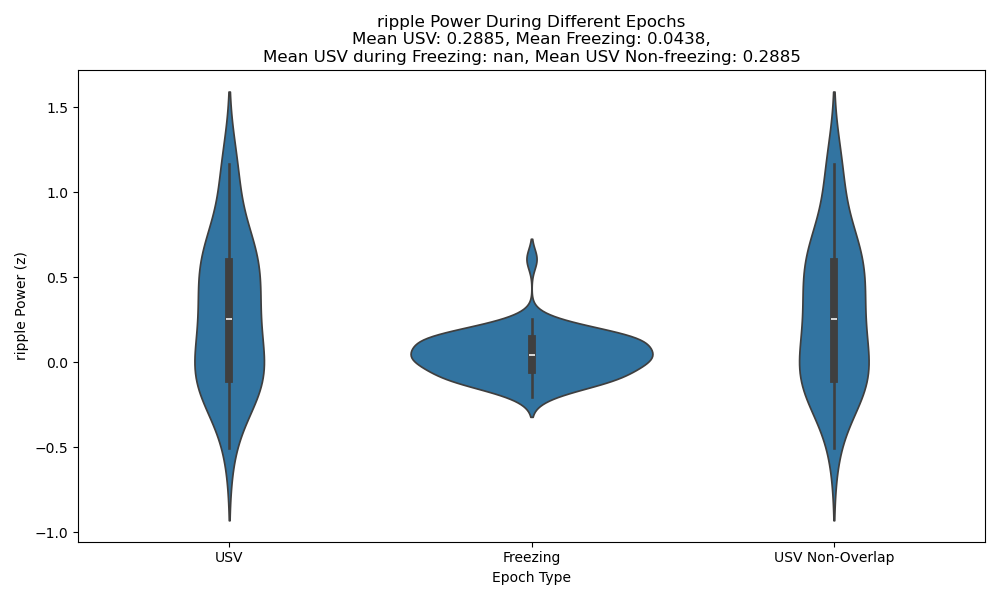

In [58]:
def categorize_usvs(usv_df, frz_df):
    usvs_during_freezing = []
    usvs_non_overlap = []
    for index, usv in usv_df.iterrows():
        overlap = False
        for _, frz in frz_df.iterrows():
            if (usv['start'] < frz['stop']) and (usv['stop'] > frz['start']):
                overlap = True
                usvs_during_freezing.append(usv)
                break
        if not overlap:
            usvs_non_overlap.append(usv)
    return pd.DataFrame(usvs_during_freezing), pd.DataFrame(usvs_non_overlap)

# Calculate the mean ripple power for a given epoch type
def calculate_ripple_power(signal, epochs_df):
    ripple_power_values = []
    for _, epoch in epochs_df.iterrows():
        power_slice = signal.time_slice(t_start=epoch['start'], t_stop=epoch['stop'])
        ripple_power_values.append(power_slice.traces[0].mean())
    return np.array(ripple_power_values)

# Convert Epoch objects to DataFrames
usv_df = usv_epochs.to_dataframe()
frz_df = frz_epochs.to_dataframe()

# Categorize USVs
usv_during_freezing_df, usv_non_overlap_df = categorize_usvs(usv_df, frz_df)

# Assuming ripple_power_sg is already correctly instantiated:
# Calculate ripple power for each epoch type
ripple_power_usv = calculate_ripple_power(ripple_power_sg, usv_df)
ripple_power_frz = calculate_ripple_power(ripple_power_sg, frz_df)
ripple_power_usv_during_freezing = calculate_ripple_power(ripple_power_sg, usv_during_freezing_df)
ripple_power_usv_non_overlap = calculate_ripple_power(ripple_power_sg, usv_non_overlap_df)

# Create DataFrame for plotting
df_usv = pd.DataFrame({"ripple Power": ripple_power_usv, "Epoch": "USV"})
df_frz = pd.DataFrame({"ripple Power": ripple_power_frz, "Epoch": "Freezing"})
df_usv_during_freezing = pd.DataFrame({"ripple Power": ripple_power_usv_during_freezing, "Epoch": "USV during Freezing"})
df_usv_non_overlap = pd.DataFrame({"ripple Power": ripple_power_usv_non_overlap, "Epoch": "USV Non-Overlap"})

ripple_power_df = pd.concat([df_usv, df_frz, df_usv_during_freezing, df_usv_non_overlap]).reset_index(drop=True)

mean_ripple_power_usv = ripple_power_usv.mean()
mean_ripple_power_frz = ripple_power_frz.mean()
mean_ripple_power_usv_during_freezing = ripple_power_usv_during_freezing.mean()
mean_ripple_power_usv_non_freezing = ripple_power_usv_non_overlap.mean()



title_text = (
    f"ripple Power During Different Epochs\n"
    f"Mean USV: {mean_ripple_power_usv:.4f}, "
    f"Mean Freezing: {mean_ripple_power_frz:.4f},\n"
    f"Mean USV during Freezing: {mean_ripple_power_usv_during_freezing:.4f}, "
    f"Mean USV Non-freezing: {mean_ripple_power_usv_non_freezing:.4f}"
)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=ripple_power_df, x="Epoch", y="ripple Power")
plt.title(title_text)
plt.xlabel("Epoch Type")
plt.ylabel("ripple Power (z)")
plt.tight_layout()
plt.show()

In [59]:
ripple_power_usvs

array([ 0.67188375,  0.98746931,  0.24334489,  0.2544151 ,  0.34661545,
        0.5215918 , -0.12773311,  0.11162459,  1.16575433,  0.72170029,
        0.61362188,  1.14170239, -0.11829972, -0.0844484 , -0.11485157,
        0.56655042,  0.68469483,  0.13619628,  0.44435851, -0.08390237,
       -0.11614195, -0.16189222,  0.69450845, -0.13806308,  0.5318755 ,
        0.39807507, -0.50210917, -0.23911179,  0.01605396,  0.2870817 ,
        0.09101094])

In [60]:
ripple_power_non_usvs

array([0.19296127, 0.2153828 , 0.22491527, 0.33173535, 0.15365383,
       0.2874713 , 0.16849608, 0.14982163])

In [61]:
ripple_power_frz

array([ 7.51672431e-02, -9.72815776e-02,  1.31797297e-01,  6.27261698e-02,
        1.64879259e-01,  1.44039185e-01,  1.13143713e-01,  1.75299173e-01,
        4.79198214e-03,  2.03243336e-01,  4.10007231e-02,  1.33580110e-01,
        1.76581895e-01,  1.35078378e-01,  9.22969272e-02, -3.79606230e-02,
        1.11531787e-02,  2.11118801e-01, -1.11722922e-01,  3.13166438e-02,
        2.56411554e-01,  7.52377999e-02,  6.07765589e-01,  1.35295471e-01,
        4.44453995e-02, -9.87633073e-02,  4.07759651e-02,  1.41966924e-01,
        3.21615505e-02,  1.25892395e-01,  1.55890173e-01,  1.49063920e-01,
       -2.69277978e-04,  1.02894257e-02, -3.66952807e-02,  1.49098611e-01,
        1.06946918e-01, -1.81273943e-01, -1.27899828e-01,  2.21126130e-01,
       -2.88515446e-02, -3.26166884e-02,  4.75830317e-02,  1.67590478e-02,
       -3.21829201e-02, -6.87534772e-02, -9.41607532e-02,  7.15044863e-02,
       -1.27924187e-01, -1.13414923e-01,  4.20890307e-02, -4.54060330e-02,
        2.20555864e-02, -

In [80]:
# swr_power_usv=ripple_power_usv
# swr_power_non_usv=ripple_power_non_usvs
# swr_power_freezing=ripple_power_frz
# def categorize_usvs(usv_df, frz_df):
#     usvs_during_freezing = []
#     usvs_non_overlap = []
#     for index, usv in usv_df.iterrows():
#         overlap = False
#         for _, frz in frz_df.iterrows():
#             if (usv['start'] < frz['stop']) and (usv['stop'] > frz['start']):
#                 overlap = True
#                 usvs_during_freezing.append(usv)
#                 break
#         if not overlap:
#             usvs_non_overlap.append(usv)
#     return pd.DataFrame(usvs_during_freezing), pd.DataFrame(usvs_non_overlap)

# # Calculate the mean swr power for a given epoch type
# def calculate_swr_power(signal, epochs_df):
#     swr_power_values = []
#     for _, epoch in epochs_df.iterrows():
#         power_slice = signal.time_slice(t_start=epoch['start'], t_stop=epoch['stop'])
#         swr_power_values.append(power_slice.traces[0].mean())
#     return np.array(swr_power_values)

# # Convert Epoch objects to DataFrames
# usv_df = usv_epochs.to_dataframe()
# frz_df = frz_epochs.to_dataframe()

# # Categorize USVs
# usv_during_freezing_df, usv_non_overlap_df = categorize_usvs(usv_df, frz_df)

# # Assuming swr_power_sg is already correctly instantiated:
# # Calculate swr power for each epoch type
# swr_power_usv = calculate_swr_power(ripple_power_sg, usv_df)
# swr_power_frz = calculate_swr_power(ripple_power_sg, frz_df)
# swr_power_usv_during_freezing = calculate_swr_power(ripple_power_sg, usv_during_freezing_df)
# swr_power_usv_non_overlap = calculate_swr_power(ripple_power_sg, usv_non_overlap_df)

# # Create DataFrame for plotting
# df_usv = pd.DataFrame({"swr Power": swr_power_usv, "Epoch": "USV"})
# df_frz = pd.DataFrame({"swr Power": swr_power_frz, "Epoch": "Freezing"})
# df_usv_during_freezing = pd.DataFrame({"swr Power": swr_power_usv_during_freezing, "Epoch": "USV during Freezing"})
# df_usv_non_overlap = pd.DataFrame({"swr Power": swr_power_usv_non_overlap, "Epoch": "USV Non-Overlap"})

# swr_power_df = pd.concat([df_usv, df_frz, df_usv_during_freezing, df_usv_non_overlap]).reset_index(drop=True)

# mean_swr_power_usv = swr_power_usv.mean()
# mean_swr_power_frz = swr_power_frz.mean()
# mean_swr_power_usv_during_freezing = swr_power_usv_during_freezing.mean()
# mean_swr_power_usv_non_freezing = swr_power_usv_non_overlap.mean()



# title_text = (
#     f"SWR Power During Different Epochs\n"
#     f"Mean USV: {mean_swr_power_usv:.4f}, "
#     f"Mean Freezing: {mean_swr_power_frz:.4f},\n"
#     f"Mean USV during Freezing: {mean_swr_power_usv_during_freezing:.4f}, "
#     f"Mean USV Non-freezing: {mean_swr_power_usv_non_freezing:.4f}"
# )

# # Plot using seaborn
# plt.figure(figsize=(10, 6))
# sns.violinplot(data=swr_power_df, x="Epoch", y="swr Power")
# plt.title(title_text)
# plt.xlabel("Epoch Type")
# plt.ylabel("swr Power (z)")
# plt.tight_layout()
# plt.show()

In [63]:
usv_epochs

31 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  918.489945  918.545653  454.143559  41.270313  0.058728   12.706250    1.0   
1  918.830174  918.913128  454.502235  48.738021  0.087452    9.696875    1.0   
2  919.498451  919.591260  455.206745  39.821354  0.097841   14.378125    1.0   
3  920.429279  920.545830  456.188042  41.381771  0.122870   12.594792    1.0   
4  920.954249  921.046723  456.741475  41.716146  0.097488    6.353125    1.0   

   Accept label  
0       1        
1       1        
2       1        
3       1        
4       1        